<a href="https://colab.research.google.com/github/pingwx/pet.proj/blob/main/masquerade/RU_masquerade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!gdown 1T1B-1mzf-nM04jXkHrfQsHE5TcHWXlP2 #download test sample

Downloading...
From: https://drive.google.com/uc?id=1T1B-1mzf-nM04jXkHrfQsHE5TcHWXlP2
To: /content/AttributedTestFaces_new.zip
100% 31.7M/31.7M [00:00<00:00, 79.2MB/s]


In [ ]:
!unzip "/content/AttributedTestFaces_new.zip" #unzip test sample

In [3]:
!gdown 1D5_xUzO0fCR_mkjt-Zpi7DM6H3d8uYlN #download train sample

Downloading...
From: https://drive.google.com/uc?id=1D5_xUzO0fCR_mkjt-Zpi7DM6H3d8uYlN
To: /content/TrueFaces_new.zip
100% 278M/278M [00:02<00:00, 122MB/s]


In [ ]:
!unzip "/content/TrueFaces_new.zip" #unzip train sample

# Маскарад

Заказчик, https://rybocop.com/mask просит разработать модель, которая смогла бы различать, как люди носят маски на лице в коронавирусное время. Это позволило бы оценить эффективность мер борьбы с инфекцией. Мы должны классифицировать изображения людей на 5 классов:


- **Класс А** - маска полностью закрывает лицо 

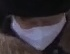

- **Класс E** - человек без макси

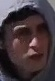

- **Класс T** - маска закрывает только рот

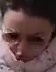

- **Класс I** - маска на подбородке

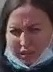

- **Класс N** - ошибки распознавания лица

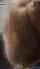

Впоследствии модель будет интегрироваться с камерами, установленными на улице города. С помощью камер и модели будет считаться число людей, носящих маски разным способом. Таким образом будет оцениваться поведение людей с течением времени. Численно будет замеряться и оцениваться динамика следующей величины:

$$StonenessIndex = \frac{I+2T+3A}{A+T+I+E}$$


## Разработка модели

Библиотеки:

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

Константы:

In [12]:
TEST_FACES_DIR = '/content/AttributedTestFaces_new'
TRAIN_FACES_DIR = '/content/TrueFaces_new'
BATCH_SIZE = 32
IMG_SIZE = 60
LABEL_NAMES = ['A', 'E', 'I', 'N', 'T']
NUM_CLASSES = 5
EPOCHS = 50
LR = 3e-4

В этой задачи модель будем строить при помощи Keras. Инициализируем датасеты в интерфейсе Keras:

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        TRAIN_FACES_DIR,
        validation_split=0.1,
        subset="training",
        seed=123,
        label_mode='categorical',
        class_names = LABEL_NAMES,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)

Found 122059 files belonging to 5 classes.
Using 109854 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        TRAIN_FACES_DIR,
        validation_split=0.1,
        subset="validation",
        seed=123,
        label_mode='categorical',
        class_names = LABEL_NAMES,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)

Found 122059 files belonging to 5 classes.
Using 12205 files for validation.


Создадим слой, выполняющий аугментацию изображений. Это необходимо, чтобы на каждой эпохе обучения, модель видела новые сэмплы изображений, таким образом мы повысим ее устойчивость, и немного защитимся от оверфиттинга.

In [9]:
data_augmentation = Sequential([
        layers.experimental.preprocessing.RandomFlip(
            "horizontal", input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.experimental.preprocessing.RandomZoom(0.1),
    ])

Зададим саму модель. Это одна из простейщих архитектур сверточной нейронной сети. В ней сперва выполняется аугментация, затем нормализация, а затем идет комбинация сверточных и пулинг слоев. На выходе у нас число нейронов равное числу классов, необходимых для нашей классификации.

In [16]:
model = Sequential([
        data_augmentation,
        layers.experimental.preprocessing.Rescaling(1. / 255),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.6),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(NUM_CLASSES)
    ])

Функция потерь и оптимизатор задаются в compile.

In [17]:
opt = tf.keras.optimizers.Adam(learning_rate=LR)

In [18]:
model.compile(optimizer=opt,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

Зададим также callback, который будет мониторить, если лосс не улучшается некоторое количество эпох, обучение останавливаем.

In [19]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Приступим к обучению.

In [20]:
history = model.fit(train_ds, epochs=EPOCHS,
                    callbacks=[callback],
                    validation_data=val_ds
                    )

Epoch 1/50
3433/3433 [==============================] - 68s 16ms/step - loss: 0.4036 - categorical_accuracy: 0.8620 - val_loss: 0.2941 - val_categorical_accuracy: 0.9000
Epoch 2/50
3433/3433 [==============================] - 57s 17ms/step - loss: 0.2827 - categorical_accuracy: 0.9014 - val_loss: 0.2203 - val_categorical_accuracy: 0.9253
Epoch 3/50
3433/3433 [==============================] - 57s 17ms/step - loss: 0.2445 - categorical_accuracy: 0.9154 - val_loss: 0.1941 - val_categorical_accuracy: 0.9327
Epoch 4/50
3433/3433 [==============================] - 54s 16ms/step - loss: 0.2191 - categorical_accuracy: 0.9235 - val_loss: 0.1795 - val_categorical_accuracy: 0.9358
Epoch 5/50
3433/3433 [==============================] - 54s 16ms/step - loss: 0.2042 - categorical_accuracy: 0.9285 - val_loss: 0.1654 - val_categorical_accuracy: 0.9415
Epoch 6/50
3433/3433 [==============================] - 54s 16ms/step - loss: 0.1905 - categorical_accuracy: 0.9341 - val_loss: 0.1547 - val_categoric

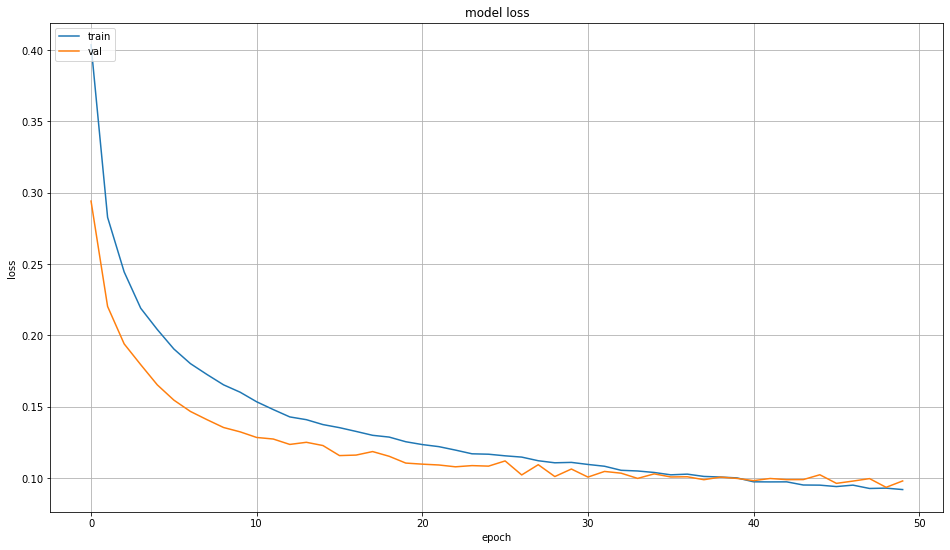

In [21]:
plt.figure(figsize=(16, 9))
plt.grid()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Модель обучена!

## Тестирование

In [22]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        TEST_FACES_DIR,
        seed=123,
        label_mode='categorical',
        class_names = LABEL_NAMES,
        image_size=(IMG_SIZE, IMG_SIZE),
        shuffle=False,
        batch_size=1)

Found 11246 files belonging to 5 classes.


In [23]:
labels_ohe = np.concatenate([y for x, y in test_ds], axis=0)
predictions_ohe = model.predict(test_ds)
labels = labels_ohe.argmax(axis=1)
predictions = predictions_ohe.argmax(axis=1)

### Classification report

In [24]:
print(classification_report(labels, predictions, zero_division=0, target_names=LABEL_NAMES))

              precision    recall  f1-score   support

           A       0.83      0.93      0.88       500
           E       0.97      0.98      0.97      7842
           I       0.91      0.91      0.91      1507
           N       0.93      0.73      0.82       613
           T       0.89      0.82      0.86       784

    accuracy                           0.95     11246
   macro avg       0.91      0.87      0.89     11246
weighted avg       0.95      0.95      0.94     11246



### Confusion matrix

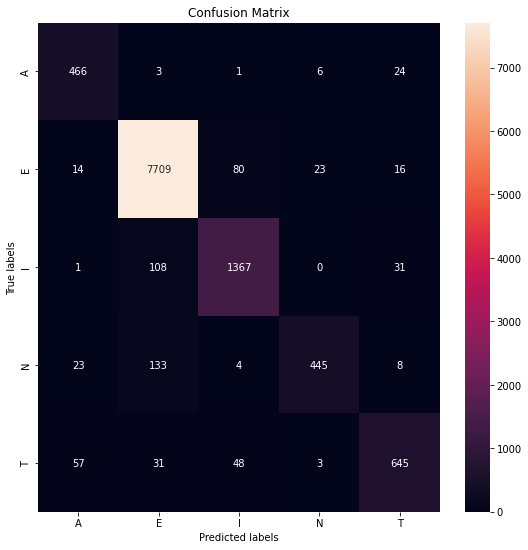

In [25]:
cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(9, 9))
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(LABEL_NAMES); ax.yaxis.set_ticklabels(LABEL_NAMES);
plt.show()

Мы наблюдаем достаточно высокую общую точность модели. Наиболее проблемным для предсказаний модели, как мы видим, является класс N. Это видно и в Classification report, и в Confusion matrix. На нем модель ошибается больше всего. То есть в расчет StonenessIndex в итоге могут попадать какие-то изображения без лиц. Вторая проблема в том, что модель путает классы T и I между собой, однако это может быть субъективным для определения и человеком.

### Распределение меток по классам

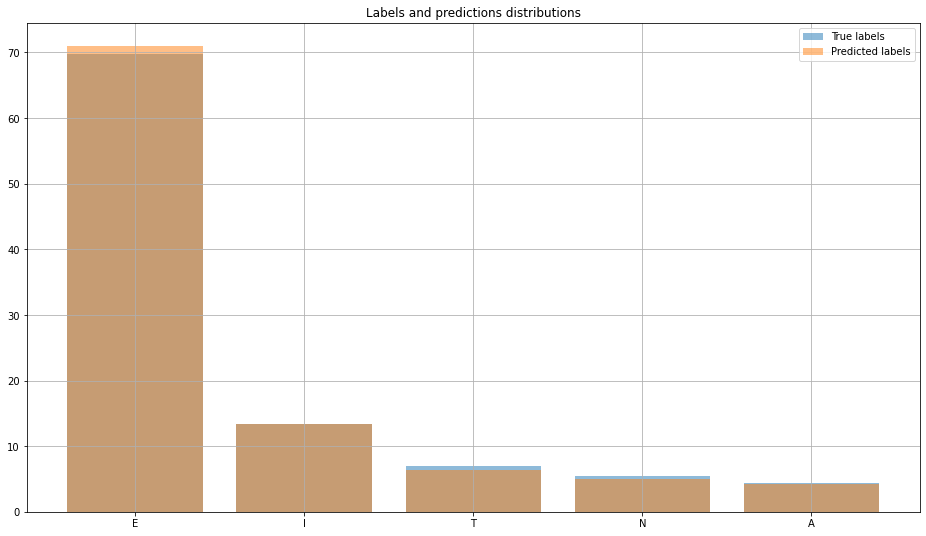

In [26]:
distribution_pred = pd.DataFrame(predictions).value_counts()/len(predictions)*100
distribution_labels = pd.DataFrame(labels).value_counts()/len(labels)*100
plt.figure(figsize=(16, 9))
plt.title('Labels and predictions distributions')
plt.grid()
plt.bar(range(len(distribution_labels)),
        distribution_labels.values,
        tick_label=['E', 'I', 'T', 'N', 'A'],
        alpha=0.5)
plt.bar(range(len(distribution_pred)),
        distribution_pred.values,
        #tick_label = distribution.index.to_list(),
        alpha=0.5)
plt.legend(['True labels', 'Predicted labels'])
plt.show()

Распределения настоящих меток и предсказанных практически одинаковы. Графики почти наложились друг на друга

### Расчет метрики заказчика

Заказчик предложил свою метрику для оценки качества построенной модели, которая похожа на accuracy, но меньше штрафует модель, если она предсказывает близкие классы. Например, классы А - маска целиком и I - маска на рту - близкие, модель получает половину штрафа. Для I близкие классы A и Т и так далее.

In [27]:
e = (cm[1, 1] + cm[1, 2] / 2) / cm[1, :].sum()
i = (cm[2, 1] / 2 + cm[2, 2] + cm[1, 2] / 2) / cm[2, :].sum()
t = (cm[4, 2] / 2 + cm[4, 4] + cm[4, 0] / 2) / cm[4, :].sum()
a = (cm[0, 4] / 2 + cm[0, 0]) / cm[0, :].sum()
n = (cm[3, 3]) / cm[3, :].sum()

print("соседей делим на два")
print('%E=', e)
print('%I=', i)
print('%T=', t)
print('%A=', a)
print('%N=', n)

trueE = cm[1, :].sum()
trueI = cm[2, :].sum()
trueT = cm[4, :].sum()
trueA = cm[0, :].sum()
trueSum = trueE + trueI + trueT + trueA

predictedE = cm[:, 1].sum()
predictedI = cm[:, 2].sum()
predictedT = cm[:, 4].sum()
predictedA = cm[:, 0].sum()
predictedSum = predictedE + predictedI + predictedT + predictedA

print('True:', 'e', trueE, 'i', trueI, 't', trueT, 'a', trueA, 'sum', trueSum)
print('Predicted:', 'e', predictedE, 'i', predictedI, 't', predictedT, 'a', predictedA, 'sum', predictedSum)

trueIdx = trueI/trueSum + 2*trueT/trueSum + 3*trueA/trueSum
predictedIdx = predictedI/predictedSum + 2*predictedT/predictedSum + 3*predictedA/predictedSum
print('trueIdx=', trueIdx, 'predictedIdx=', predictedIdx)

print('FINAL SCORE:',(e+i+t+a+n) / 5 - abs(trueIdx - predictedIdx))

соседей делим на два
%E= 0.9881407804131599
%I= 0.9694757796947578
%T= 0.8896683673469388
%A= 0.956
%N= 0.7259380097879282
True: e 7842 i 1507 t 784 a 500 sum 10633
Predicted: e 7984 i 1500 t 724 a 561 sum 10769
trueIdx= 0.4302642716072604 predictedIdx= 0.4300306435137896
FINAL SCORE: 0.9056109593550861


## Итоги

Построенная модель была успешно внедрена на https://rybocop.com/mask и теперь мы наглядно наблюдаем, как меняются настроения людей в российской провинции относительно ношения масок.